In [13]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
from gensim.corpora import Dictionary as CorporaDictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
%matplotlib inline

In [2]:
# create list of strings, each string representing one article
# there are a variable number of articles per file
corpus = []
for txt in sorted(Path('Articles').iterdir()):
    with open(txt) as f:
        # split article on \f (feed file character)
        documents = "\n".join(f.readlines()).split("\f")
        corpus.extend(documents)

# there are 1622 articles in the corpus
len(corpus)

1622

In [3]:
# skip metadata at beginning and end of every document
def remove_metadata(document: str) -> str:
    lines = [line for l in document.split("\n") if (line := l.strip())]
    for i, line in enumerate(lines):
        lower_line = line.lower()
        # slice article after copyright (usually lines 10-11)
        if lower_line.startswith("copyright") or lower_line.startswith("©"):
            # slice article before the document ID (last line)
            return "\n".join(lines[i + 1: -1])

In [4]:

TOKENIZER = RegexpTokenizer(r"\w+")  # splits on any non-word character
LEMMATIZER = WordNetLemmatizer()
# STEMMER = SnowballStemmer('english')

# removing the lemmas "say" and "mr" because a lot of these articles are from the NYT and they use those a lot
STOPWORDS = set(stopwords.words('english')) | {"say", "mr"}

def preprocess_text(text: str) -> str:
    
    # remove metadata using above function
    meta_stripped = remove_metadata(text)
    
    # tokenize, remove punctuation
    tokens: list[str] = TOKENIZER.tokenize(meta_stripped)

    # lowercase all, lemmatize verbs
    lemmas = [LEMMATIZER.lemmatize(token.lower(), pos="v") for token in tokens]
    
    # # stem tokens
    # stems = [STEMMER.stem(l) for l in lemmas]

    # remove stopwords, numbers, and non-english words
    keywords = [w for w in lemmas if all((w not in STOPWORDS, w.isascii(), w.isalpha()))]
    
    return " ".join(keywords)

In [5]:
# create list of preprocessed strings, each string is an article (document)
processed_corpus = [preprocess_text(document) for document in corpus]

In [6]:
# extract features using TF-IDF and store in pandas dataframe
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_corpus).toarray()
tokens = vectorizer.get_feature_names_out()
df = pd.DataFrame(data=X, columns=tokens)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Columns: 32752 entries, aa to zyed
dtypes: float64(32752)
memory usage: 405.3 MB


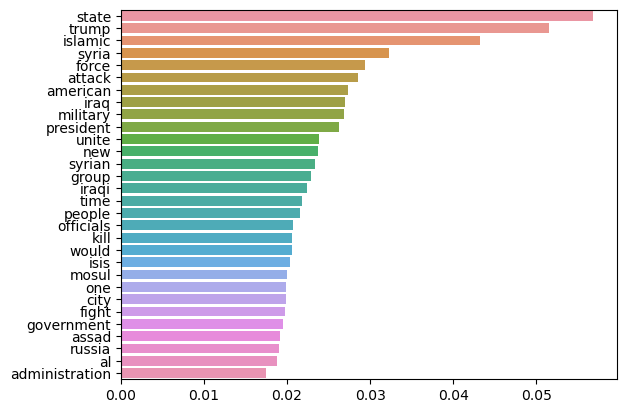

In [8]:
top_30 = df.mean().sort_values(ascending=False)[:30]
sns.barplot(y=top_30.index, x=top_30)
plt.show()

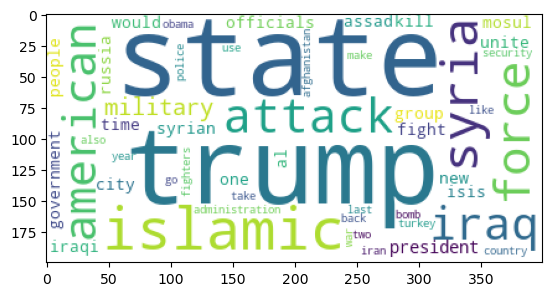

In [9]:
wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.imshow(wordcloud)
plt.show()

In [14]:
texts = [document.split() for document in processed_corpus]

# Creates, which is a mapping of word IDs to words.
id2word = CorporaDictionary(texts)

# Turns each document into a bag of words.
bows = [id2word.doc2bow(text) for text in texts]

In [11]:
lda_model = LdaModel(corpus=bows,
    id2word=id2word,
    num_topics=10, 
    random_state=42,
    update_every=1,
    passes=10,
    alpha='auto',
    per_word_topics=True)

In [12]:
lda_model.print_topics()

[(0,
  '0.023*"state" + 0.019*"islamic" + 0.012*"force" + 0.011*"syria" + 0.008*"syrian" + 0.008*"u" + 0.007*"group" + 0.007*"military" + 0.007*"iraq" + 0.007*"american"'),
 (1,
  '0.011*"trump" + 0.007*"turkey" + 0.007*"state" + 0.006*"day" + 0.005*"kurds" + 0.005*"would" + 0.004*"erdogan" + 0.004*"president" + 0.004*"order" + 0.004*"kurdish"'),
 (2,
  '0.006*"facebook" + 0.006*"time" + 0.005*"people" + 0.005*"new" + 0.005*"news" + 0.005*"like" + 0.005*"one" + 0.004*"make" + 0.004*"would" + 0.003*"trump"'),
 (3,
  '0.013*"attack" + 0.012*"state" + 0.010*"kill" + 0.009*"islamic" + 0.006*"bomb" + 0.006*"police" + 0.006*"group" + 0.005*"afghanistan" + 0.005*"people" + 0.005*"officials"'),
 (4,
  '0.010*"state" + 0.008*"new" + 0.007*"time" + 0.006*"trump" + 0.006*"iraq" + 0.005*"york" + 0.005*"iraqi" + 0.005*"president" + 0.005*"islamic" + 0.005*"unite"'),
 (5,
  '0.010*"go" + 0.010*"trump" + 0.009*"think" + 0.007*"get" + 0.006*"gigot" + 0.006*"president" + 0.006*"people" + 0.005*"one" + 

In [15]:
# Compute Perplexity
print(f'\nPerplexity: {lda_model.log_perplexity(bows)}')  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')


Perplexity: -8.087778177948985

Coherence Score: 0.4029953164182576


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bows, id2word)
vis

/home/bsu/anaconda3/envs/textmining/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.090177 -0.103163       1        1  18.977983
6     -0.070139  0.035239       2        1  18.018158
5      0.084467  0.070973       3        1  17.200326
4     -0.010917 -0.014834       4        1   9.934352
2      0.095016  0.040980       5        1   8.908455
9      0.074384 -0.061871       6        1   8.135083
3     -0.029370 -0.103381       7        1   7.916178
8      0.095124 -0.030901       8        1   5.655445
7     -0.074599  0.070145       9        1   3.636013
1     -0.073789  0.096814      10        1   1.618007, topic_info=         Term          Freq         Total Category  logprob  loglift
457     trump   7425.000000   7425.000000  Default  30.0000  30.0000
413     state  10415.000000  10415.000000  Default  29.0000  29.0000
467     unite   3370.000000   3370.000000  Default  28.0000  28.0000
220   islamic   6108.000000   6108.000000  Default  27.0000  27.0000
303     order   1418.000000   1418.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
467     unite     45.988289   3370.054223  Topic10  -5.8913  -0.1703
1673    white     40.894076   1401.277842  Topic10  -6.0087   0.5898
760     group     41.574421   3259.362117  Topic10  -5.9922  -0.2378
218      isis     41.412076   3088.563888  Topic10  -5.9962  -0.1879
207     house     40.967204   1831.766562  Topic10  -6.0070   0.3237

[871 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
837        1  0.375919       abadi
837        2  0.076458       abadi
837        3  0.003186       abadi
837        4  0.528836       abadi
837        6  0.003186       abadi
...      ...       ...         ...
2511       1  0.983203        zour
24461      5  0.956327        zuck
4007       3  0.007286  zuckerberg
4007       5  0.961718  zuckerberg
4007       8  0.014571  zuckerberg

[3304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 5, 3, 10, 4, 9, 8, 2])